# 닮은 꼴 연예인 찾기 앱 만들기 😎

## 학습목표

1. 임베딩에 대해 이해하고 얼굴의 임베딩 벡터를 추출한다.
2. 얼굴의 임베딩 벡터로 닮은 꼴인 얼굴을 찾는다.
3. 가장 닮은 연예인을 찾아낸다

> __임베딩이란?__
고차원 정보를 저차원으로 변환하면서 필요한 정보를 보존하는 것이다.
임베딩은 임베딩 공간에서 의미적으로 비슷한 입력 사항들을 가깝게 배치함으로써 입력에 포함된 의미 중 일부를 포착한다.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import face_recognition
%matplotlib inline
from PIL import Image
from tqdm import tqdm

## 1. 데이터 준비

- 내 사진을 포함한 80명의 연예인 사진을 저장하고 불러온다.

In [2]:
# 이미지 불러오기
dir_path = os.getenv('HOME')+'/aiffel/face_embedding/pjt_images'
file_list = os.listdir(dir_path)

print("사용할 이미지 파일 갯수는 {}개 입니다.".format(len(file_list)))
print(file_list[0]) # 첫번째 이미지 파일 확인

사용할 이미지 파일 갯수는 83개 입니다.
EunyeongPark2.jpg


## 2. 얼굴영역 자르기
1. face_recognition.face_locations()를 이용해 얼굴 영역을 좌표를 얻는다.
2. 얻은 좌표를 이용해 얼굴영역을 자른다,
3. Image.fromarray()를 이용해 Numpy 배열을 이미지로 저장한다.

In [3]:
# 이미지 파일에서 얼굴영역을 crop한다
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a,b,c,d = face_locations[0]
    cropped_face = image[a:c, d:b, :]
    return cropped_face

In [4]:
# 얼굴영역을 잘라서 이미지로 저장한다.
for file in tqdm(file_list):

    # 이미지 파일 불러오기
    image_path = os.path.join(dir_path, file)
    try:
        # 얼굴영역 크롭
        face = get_cropped_face(image_path)

        # 크롬된 이미지 저장
        path_to_save = os.getenv('HOME')+'/aiffel/face_embedding/cropped_faces'
        pillow_image = Image.fromarray(face)
        pillow_image.save(os.path.join(path_to_save, file))
    
    except (IsADirectoryError): # 체크포인트 파일인 경우 넘어가기
        pass   
    except: # 크롭이 안되는 파일 제거하기
        os.remove(image_path)
        print(file," 삭제")

100%|██████████| 83/83 [01:20<00:00,  1.03it/s]


## 3. 얼굴 영역의 임베딩 추출하기

1. face_recognition.face_encodings()를 이용해 얼굴 임베딩 벡터를 구한다.
2. 딕셔너리에 파일명을 key, 임베딩 벡터를 value로 저장한다.

In [5]:
# 얼굴영역으로부터 얼굴 임베딩 벡터를 구하기
def get_face_embedding(cropped_face):
    return face_recognition.face_encodings(cropped_face) # 이미지를 128차원으로 만들어준다.

In [6]:
# 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 만들기
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    try:
        for file in file_list:
            img_path = os.path.join(dir_path, file)
            cropped_img = get_cropped_face(img_path)
            embedding = get_face_embedding(cropped_img)
            if len(embedding) > 0: # face detect가 실패시 임베딩 길이 0
                embedding_dict[os.path.splitext(file)[0]] = embedding[0]
                # os.path.splittext(file)[0] 에는 확장자제거된 파일명만 남는다
    
    except (IsADirectoryError):
        pass        
    
    return embedding_dict

In [7]:
embedding_dict = get_face_embedding_dict(dir_path)
print("생성된 임베딩 사전의 단어의 개수는 {}개 입니다.".format(len(embedding_dict)))

생성된 임베딩 사전의 단어의 개수는 69개 입니다.


## 4. 얼굴임베딩 사이의 거리측정

1. 연산을 위해 벡터를 numpy array로 변환해준다.
2. 각 벡터간의 거리를 numpy.linalg.norm()을 활용해 L2 Norm Distance로 계산한다.


> __L2 Norm Distance__<br>
모델 결과물의 L2 Distance를 가지고 결과물을 나누어 Nomalization 해주는 과정이다.
L2 Normalization 레이어를 거쳐 나온 임베딩 벡터는 두 벡터의 절대적 크기에 무관하게 벡터 사이의 각도에만 영향을 받는다. <br><br>
$$d(p,q) = d(q,p)=\sqrt{(q_1-p_1)^2+(q_2-p_2)^2+ ...+(q_n-p_n)^2} = \sqrt{\sum_{i=1}^n{(q_i-p_i)^2}}$$

> __Triplet loss__<br>
세 개의 데이터 쌍을 이용해 계산하는 손실함수로 네트워크를 학습시킬 수 있다. 유사한 벡터(같은 사람)는 가깝게, 다른 벡터(다른 사람)를 멀게 학습을 시키는 효과를 가져온다.

동일인물의 사진 2장(Anchor, Positive)과 다른인물의 사진 1장을 가지고 얼굴임베딩 사이의 거리를 측정해본다.

In [8]:
anchor = embedding_dict['jiapark2']
positive = embedding_dict['jiapark3']
negative = embedding_dict['hyoju']

In [9]:
# 임베딩 사이의 거리 측정
distances = np.linalg.norm([positive, negative] - anchor, axis=1, ord=2)
print("Distance between Positive and Anchor: {}".format(distances[0]))
print("Distance between Negative and Anchor: {}".format(distances[1]))

Distance between Positive and Anchor: 0.27562598456948795
Distance between Negative and Anchor: 0.5620591520128829


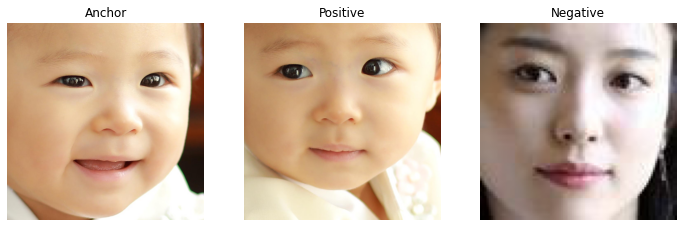

In [10]:
# 이미지 출력
path_to_save = os.getenv('HOME')+'/aiffel/face_embedding/cropped_faces'
cropped_anchor = Image.open(os.path.join(path_to_save, 'jiapark2.jpg'))
cropped_positive = Image.open(os.path.join(path_to_save, 'jiapark3.jpg'))
cropped_negative = Image.open(os.path.join(path_to_save, 'hyoju.jpg'))

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.imshow(cropped_anchor)
plt.title('Anchor')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cropped_positive)
plt.title('Positive')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cropped_negative)
plt.title('Negative')
plt.axis('off')

plt.show()

동일인물의 얼굴 임베딩 사이의 거리는 약 0.27, 다른인물과의 차이는 약 0.56으로 동일인물의 사진이 벡터거리가 가까운 점을 확인할 수 있다.

In [11]:
# 두 사람의 얼굴 임베딩 사이의 거리(L2 distance)를 구한다.
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

## 5. 닮은 꼴 연예인 찾기

In [12]:
# name1과 name2의 거리를 비교하는 함수를 생성.
# name1은 미리 지정하고, name2는 호출시에 인자로 받도록 한다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [28]:
# 가장 닮은 다른 이미지와 거리 정보를 가까운 순으로 정렬해서 표시
def get_nearest_face(name, top=5):
    
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    dict_top5 = dict()
    for i in range(top+2):
        if i==0: # 첫번째로 나오는 이름은 자기자신이기 때문에 제외
            continue
        elif sorted_faces[i][0].startswith('Eunyeong'):   # 나의 다른 사진도 제외
            continue
        elif sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i-1, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            dict_top5[sorted_faces[i][0]] = sort_key_func(sorted_faces[i][0])
    return dict_top5

In [29]:
dict_top5 = get_nearest_face('EunyeongPark1', top=5)

순위 1 : 이름(DasolKim), 거리(0.3382053680031169)
순위 2 : 이름(EJHan), 거리(0.34741174419817067)
순위 3 : 이름(DamiKim), 거리(0.3494633349229763)
순위 4 : 이름(SYHan), 거리(0.35020726461442614)
순위 5 : 이름(JHHan2), 거리(0.3589347609503306)


In [30]:
dict_top5 = get_nearest_face('EunyeongPark2', top=5)

순위 1 : 이름(DamiKim), 거리(0.3392505190815912)
순위 2 : 이름(EJHan), 거리(0.34782707978239963)
순위 3 : 이름(DasolKim), 거리(0.3622380704307867)
순위 4 : 이름(JHHan2), 거리(0.37904294538258226)
순위 5 : 이름(SYPark), 거리(0.38173374867539306)


## 6. Top 5 사진 출력

In [79]:
def show_top5_images(name):
    fig = plt.figure(figsize=(10, 5))
    rows, cols = 1, 6
    i = 1
    
    name_list = [name] + list(dict_top5.keys())
    top5_score = list(map(lambda x: round(x,2), list(dict_top5.values())))
    score_list = ['Anchor'] + top5_score
    
    for name in name_list:
        dir_path = os.getenv('HOME')+'/aiffel/face_embedding/cropped_faces'
        file = [file for file in os.listdir(dir_path) if file.startswith(name)][0]
        img_path = os.path.join(dir_path, file)
        img = Image.open(img_path)
        ax = fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        ax.set_title(score_list[i-1])
        i += 1
    
    plt.show()

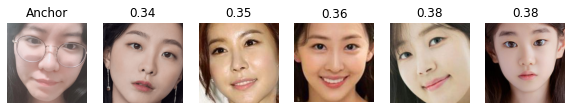

In [80]:
show_top5_images('EunyeongPark1')

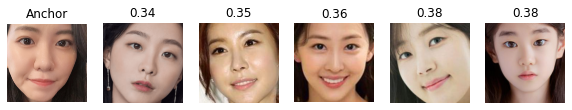

In [81]:
show_top5_images('EunyeongPark2')

안경을 쓴 사진과 벗은 사진 모두 Top5 결과가 같았다. 내 사진 끼리의 얼굴 임베딩 거리가 0.24로 매우 가까웠기 때문에 결과도 같게 나온것 같다.